In [1]:
from swiper2.schedule_experiments import MemorySchedule, RegularTSchedule, MSD15To1Schedule
from swiper2.device_manager import DeviceManager
from swiper2.window_builder import WindowBuilder
from swiper2.window_manager import SlidingWindowManager
from swiper2.decoder_manager import DecoderManager
from swiper2.simulator import DecodingSimulator
import swiper2.plot as plotter

import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.animation as animation

In [2]:
def draw_dag(G):
    for layer, nodes in enumerate(nx.topological_generations(G)):
        # `multipartite_layout` expects the layer as a node attribute, so add the
        # numeric layer value as a node attribute
        for node in nodes:
            G.nodes[node]["layer"] = layer

    # Compute the multipartite_layout using the "layer" node attribute
    pos = nx.multipartite_layout(G, subset_key="layer")

    nx.draw_networkx(G, pos=pos)

# Sliding Window Scheme

## Regular T Schedule, instant bad speculations

In [3]:
d=7
decoding_time = 2*d
# speculation_time = 100*d
speculation_time = 0
speculation_accuracy = 0

In [4]:
simulator = DecodingSimulator(d, lambda _: decoding_time, speculation_time, speculation_accuracy, speculation_mode='separate')

In [5]:
device_data, window_data, decoding_data = simulator.run(
    schedule=RegularTSchedule(2,0).schedule,
    scheduling_method='sliding',
    enforce_window_alignment=False,
    max_parallel_processes=None,
    progress_bar=True,
)

Surface code rounds: 329it [00:00, 4570.02it/s]


In [6]:
decoding_data.num_rounds

329

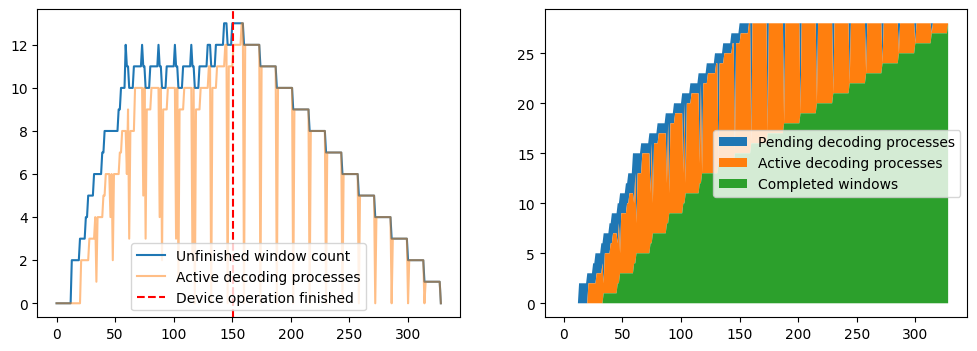

In [7]:
fig,ax = plt.subplots(1,2, figsize=(12,4))

ax[0].plot(range(decoding_data.num_rounds), np.array(window_data.window_count_history) - np.array(decoding_data.completed_windows_by_round), label='Unfinished window count')
ax[0].plot(range(decoding_data.num_rounds), decoding_data.parallel_processes_by_round, alpha=0.5, label='Active decoding processes')
ax[0].axvline(x=device_data.num_rounds, color='r', linestyle='--', label='Device operation finished')
ax[0].legend()

ax[1].fill_between(range(decoding_data.num_rounds), decoding_data.completed_windows_by_round+decoding_data.parallel_processes_by_round, window_data.window_count_history, label='Pending decoding processes')
ax[1].fill_between(range(decoding_data.num_rounds), decoding_data.completed_windows_by_round, decoding_data.completed_windows_by_round + decoding_data.parallel_processes_by_round, label='Active decoding processes')
ax[1].fill_between(range(decoding_data.num_rounds), 0, decoding_data.completed_windows_by_round, label='Completed windows')
ax[1].legend()

Observe a significant amount of redundant work (many decoding processes
happening in parallel, but number of completed windows is only increasing
gradually - because most of the decoding processes are based on faulty
speculations and must be recomputed later)

## RegularTSchedule, not using speculation

Here, speculation time is much longer than decoding time, so we are just doing
standard sliding window.

In [8]:
d=7
decoding_time = 2*d
speculation_time = 100*d
# speculation_time = 0
speculation_accuracy = 0

In [9]:
simulator = DecodingSimulator(d, lambda _: decoding_time, speculation_time, speculation_accuracy, speculation_mode='separate')

In [10]:
device_data, window_data, decoding_data = simulator.run(
    schedule=RegularTSchedule(2,0).schedule,
    scheduling_method='sliding',
    enforce_window_alignment=False,
    max_parallel_processes=None,
    progress_bar=True,
)

Surface code rounds: 329it [00:00, 5542.01it/s]


In [11]:
decoding_data.num_rounds

329

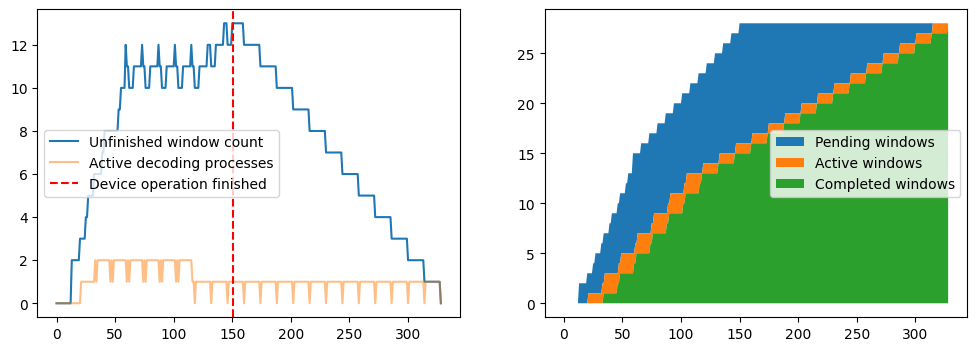

In [12]:
fig,ax = plt.subplots(1,2, figsize=(12,4))

ax[0].plot(range(decoding_data.num_rounds), np.array(window_data.window_count_history) - np.array(decoding_data.completed_windows_by_round), label='Unfinished window count')
ax[0].plot(range(decoding_data.num_rounds), decoding_data.parallel_processes_by_round, alpha=0.5, label='Active decoding processes')
ax[0].axvline(x=device_data.num_rounds, color='r', linestyle='--', label='Device operation finished')
ax[0].legend()

ax[1].fill_between(range(decoding_data.num_rounds), decoding_data.completed_windows_by_round+decoding_data.parallel_processes_by_round, window_data.window_count_history, label='Pending windows')
ax[1].fill_between(range(decoding_data.num_rounds), decoding_data.completed_windows_by_round, decoding_data.completed_windows_by_round + decoding_data.parallel_processes_by_round, label='Active windows')
ax[1].fill_between(range(decoding_data.num_rounds), 0, decoding_data.completed_windows_by_round, label='Completed windows')
ax[1].legend()

Observe that the number of active decoding processes is far lower, but the rate
of completing windows remains the same.

<Axes3D: >

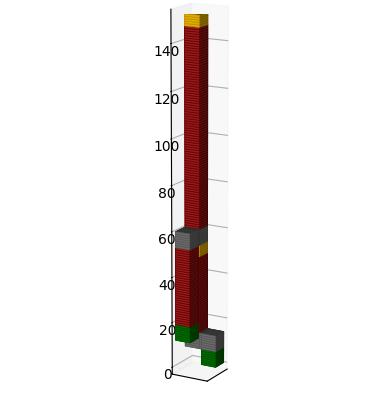

In [13]:
plotter.plot_device_schedule_trace(device_data)

<Axes3D: >

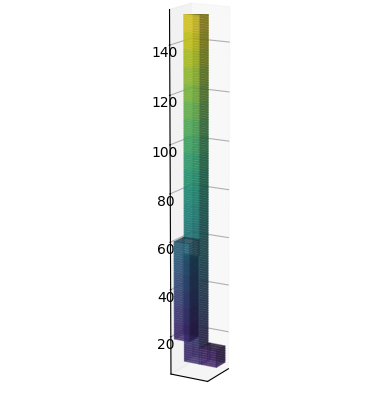

In [14]:
window_completion_times = decoding_data.window_completion_times
plotter.plot_device_schedule_trace(
    device_data,
    windows=window_data.all_windows, 
    window_schedule_times=[window_completion_times[w] for w in window_data.all_windows],
)

## 15 - 1 Factory

<font color=red>VERIFY CORRECTNESS</font>

In [15]:
d=7
decoding_time = 2*d
speculation_time = 100*d
speculation_accuracy = 0

In [16]:
simulator = DecodingSimulator(d, lambda _: decoding_time, speculation_time, speculation_accuracy, speculation_mode='separate')

In [17]:
device_data, window_data, decoding_data = simulator.run(
    schedule=MSD15To1Schedule().schedule,
    scheduling_method='sliding',
    enforce_window_alignment=False,
    max_parallel_processes=None,
    progress_bar=True,
)

Surface code rounds: 329it [00:02, 155.75it/s]


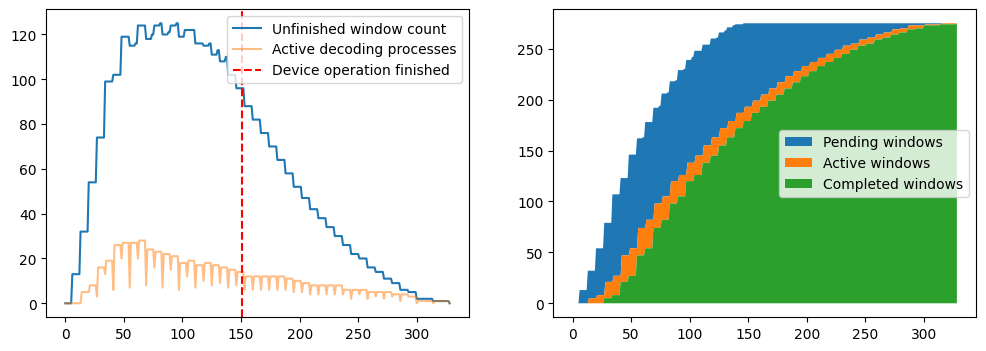

In [18]:
fig,ax = plt.subplots(1,2, figsize=(12,4))

ax[0].plot(range(decoding_data.num_rounds), np.array(window_data.window_count_history) - np.array(decoding_data.completed_windows_by_round), label='Unfinished window count')
ax[0].plot(range(decoding_data.num_rounds), decoding_data.parallel_processes_by_round, alpha=0.5, label='Active decoding processes')
ax[0].axvline(x=device_data.num_rounds, color='r', linestyle='--', label='Device operation finished')
ax[0].legend()

ax[1].fill_between(range(decoding_data.num_rounds), decoding_data.completed_windows_by_round+decoding_data.parallel_processes_by_round, window_data.window_count_history, label='Pending windows')
ax[1].fill_between(range(decoding_data.num_rounds), decoding_data.completed_windows_by_round, decoding_data.completed_windows_by_round + decoding_data.parallel_processes_by_round, label='Active windows')
ax[1].fill_between(range(decoding_data.num_rounds), 0, decoding_data.completed_windows_by_round, label='Completed windows')
ax[1].legend()

<Axes3D: >

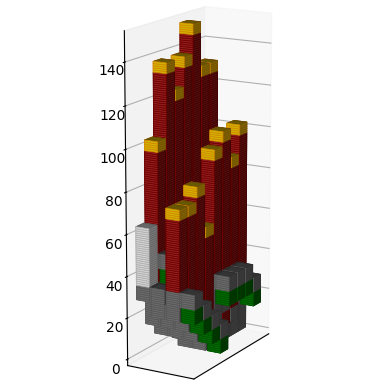

In [19]:
plotter.plot_device_schedule_trace(device_data, spacing=1)

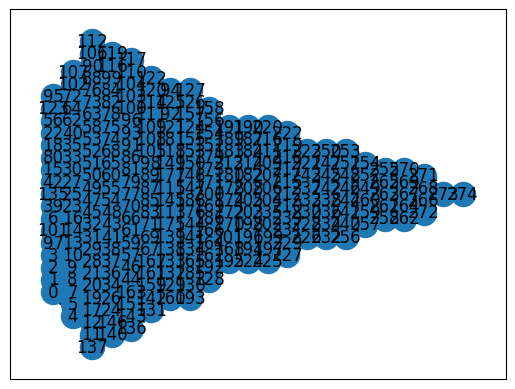

In [20]:
draw_dag(window_data.window_dag)

<Axes3D: >

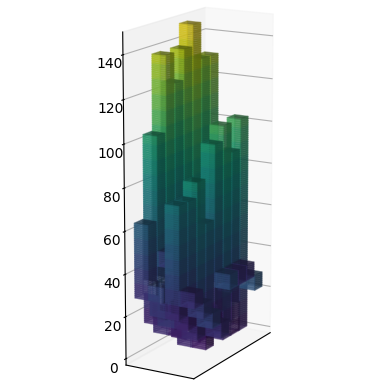

In [21]:
window_completion_times = decoding_data.window_completion_times
plotter.plot_device_schedule_trace(
    device_data,
    spacing=1,
    windows=window_data.all_windows, 
    window_schedule_times=[window_completion_times[w] for w in window_data.all_windows],
)

# Stress test

In [22]:
d=7
decoding_time = 2*d
speculation_time = 2
speculation_accuracy = 0.7

In [23]:
simulator = DecodingSimulator(d, lambda _: decoding_time, speculation_time, speculation_accuracy, speculation_mode='separate')

In [24]:
device_data, window_data, decoding_data = simulator.run(
    schedule=RegularTSchedule(100, 0).schedule,
    scheduling_method='sliding',
    enforce_window_alignment=False,
    max_parallel_processes=None,
    progress_bar=True,
)
print(device_data.num_rounds, decoding_data.num_rounds)

Surface code rounds: 4608it [00:14, 314.13it/s]

4591 4608


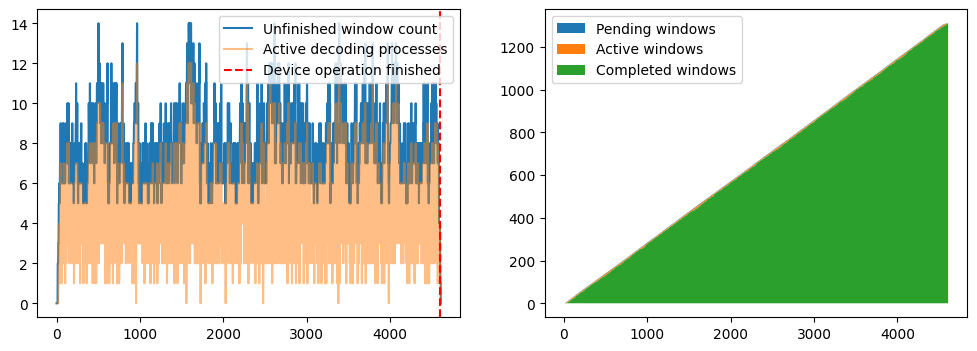

In [25]:
fig,ax = plt.subplots(1,2, figsize=(12,4))

ax[0].plot(range(decoding_data.num_rounds), np.array(window_data.window_count_history) - np.array(decoding_data.completed_windows_by_round), label='Unfinished window count')
ax[0].plot(range(decoding_data.num_rounds), decoding_data.parallel_processes_by_round, alpha=0.5, label='Active decoding processes')
ax[0].axvline(x=device_data.num_rounds, color='r', linestyle='--', label='Device operation finished')
ax[0].legend()

ax[1].fill_between(range(decoding_data.num_rounds), decoding_data.completed_windows_by_round+decoding_data.parallel_processes_by_round, window_data.window_count_history, label='Pending windows')
ax[1].fill_between(range(decoding_data.num_rounds), decoding_data.completed_windows_by_round, decoding_data.completed_windows_by_round + decoding_data.parallel_processes_by_round, label='Active windows')
ax[1].fill_between(range(decoding_data.num_rounds), 0, decoding_data.completed_windows_by_round, label='Completed windows')
ax[1].legend()